<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/GAN_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Stephanie Tietz

Adversarial GAN

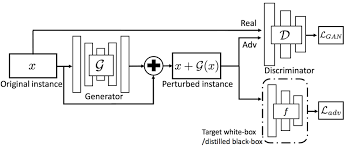

In [0]:
#First train the generator, specifiy whether or not you want it to be targeted
#Different generator will be trained for each target
#After training, call "attack" to load weights from generator and run attack on test set
#print out before and after picture of two images from last batch
#Github author: ctargon https://github.com/ctargon/AdvGAN-tf

In [0]:
#Generator
'''
	Generator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''

import tensorflow as tf

# helper function for convolution -> instance norm -> relu
def ConvInstNormRelu(x, filters, kernel_size=3, strides=1):
	Conv = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(Conv)

	return tf.nn.relu(InstNorm)


# helper function for trans convolution -> instance norm -> relu
def TransConvInstNormRelu(x, filters, kernel_size=3, strides=2):
	TransConv = tf.layers.conv2d_transpose(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(TransConv)

	return tf.nn.relu(InstNorm)

# helper function for residual block of 2 convolutions with same num filters
# in the same style as ConvInstNormRelu
def ResBlock(x, training, filters=32, kernel_size=3, strides=1):
	conv1 = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv1_norm = tf.layers.batch_normalization(conv1, training=training)

	conv1_relu = tf.nn.relu(conv1_norm)

	conv2 = tf.layers.conv2d(
						inputs=conv1_relu,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv2_norm = tf.layers.batch_normalization(conv2, training=training)


	return x + conv2_norm


def generator(x, training):
	with tf.variable_scope('g_weights', reuse=tf.AUTO_REUSE):
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])

		# define first three conv + inst + relu layers
		c1 = ConvInstNormRelu(x, filters=8, kernel_size=3, strides=1)
		d1 = ConvInstNormRelu(c1, filters=16, kernel_size=3, strides=2)
		d2 = ConvInstNormRelu(d1, filters=32, kernel_size=3, strides=2)

		# define residual blocks
		rb1 = ResBlock(d2, training, filters=32)
		rb2 = ResBlock(rb1, training, filters=32)
		rb3 = ResBlock(rb2, training, filters=32)
		rb4 = ResBlock(rb3, training, filters=32)

		# upsample using conv transpose
		u1 = TransConvInstNormRelu(rb4, filters=16, kernel_size=3, strides=2)
		u2 = TransConvInstNormRelu(u1, filters=8, kernel_size=3, strides=2)

		# final layer block
		out = tf.layers.conv2d_transpose(
						inputs=u2,
						filters=x.get_shape()[-1].value, # or 3 if RGB image
						kernel_size=3,
						strides=1,
						padding="same",
						activation=None)

		# out = tf.contrib.layers.instance_norm(out)

		return tf.nn.tanh(out)


In [0]:
#Discriminator
'''
	Discriminator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''

import tensorflow as tf

def discriminator(x, training):
	with tf.variable_scope('d_weights', reuse=tf.AUTO_REUSE):
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])

		conv1 = tf.layers.conv2d(
							inputs=x,
							filters=8,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)
		conv1 = tf.nn.leaky_relu(conv1, alpha=0.2)

		
		conv2 = tf.layers.conv2d(
							inputs=conv1,
							filters=16,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		in1 = tf.contrib.layers.instance_norm(conv2)
		conv2 = tf.nn.leaky_relu(in1, alpha=0.2)

		conv3 = tf.layers.conv2d(
							inputs=conv2,
							filters=32,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		#in2 = tf.contrib.layers.instance_norm(conv3)
		in2 = tf.contrib.layers.instance_norm(conv3)
		conv3 = tf.nn.leaky_relu(in2, alpha=0.2)
		flat = tf.layers.flatten(conv3)
		logits = tf.layers.dense(flat, 1)

		probs = tf.nn.sigmoid(logits)

		return logits, probs